In [25]:
import gensim
from gensim import utils
import numpy as np
import sys
from sklearn.datasets import fetch_20newsgroups
from nltk import word_tokenize
from nltk import download
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

In [26]:
import nltk
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

In [27]:
import pandas as pd

In [28]:
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [29]:
amc = pd.read_csv('dool_ml')

In [30]:
character = list(amc['speaker'].value_counts()[:20].index)

In [31]:
amc = amc.loc[amc['speaker'].isin(character)]

In [8]:
amc['speech'] = amc['speech'].fillna('')

In [9]:
import random

In [10]:
df = pd.DataFrame(columns=list(amc))

In [11]:
df

,Unnamed: 0,Unnamed: 0.1,count,show_date,Unnamed: 0.1.1,Unnamed: 0.1.1.1,filename,opera_name,show_year,scene,turn,text,speaker,speech,gender,date_scene,F,M


In [12]:
for i in character:
    temp = amc.loc[amc['speaker'] == i]
    df = df.append(temp.sample(1000))

In [13]:
df['tokenized_words'] = df['speech'].apply(lambda x: nltk.word_tokenize(x))
df['normalized_words'] = df['tokenized_words'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = None))

In [14]:
texts, y = list(df['speech']), list(df['speaker'])

In [15]:
corpus = [text for text in df['normalized_words']]

In [16]:
import math

def magnitude(v):
    return math.sqrt(sum(v[i]*v[i] for i in range(len(v))))

def normalize(v):
    vmag = magnitude(v)
    return [ v[i]/vmag  for i in range(len(v)) ]

In [17]:
def filter_docs(corpus, texts, labels, condition_on_doc):
    number_of_docs = len(corpus)

    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if condition_on_doc(doc)]

    labels = [i for (i, doc) in zip(labels, corpus) if condition_on_doc(doc)]
    corpus = [doc for doc in corpus if condition_on_doc(doc)]

    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts, labels)

def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in word2vec_model.vocab]
    temp = word2vec_model[doc]
    lst = []
    for j in temp:
        tempo = normalize(j)
        lst.append(tempo)
    return np.mean(lst, axis=0)


def has_vector_representation(word2vec_model, doc):
    return not all(word not in word2vec_model.vocab for word in doc)


In [18]:
corpus, texts, y = filter_docs(corpus, texts, y, lambda doc: has_vector_representation(model, doc))

841 docs removed


In [19]:
x =[]
for doc in corpus: #look up each doc in model
    x.append(document_vector(model, doc))

Building a List of vectors

In [20]:
amc_character = list(set(y))

In [21]:
import itertools

In [22]:
import sklearn

In [23]:
vector_lst = []
for character in amc_character:
    indexes = [i for i,v in enumerate(y) if v == character]
    cha_lst = [x[k] for k in list(itertools.compress(indexes, y))]   
    vector_lst.append(cha_lst)

In [24]:
cosine_similarity_matrix = []
c = 0
for i in vector_lst:
    c += 1
    heatmapMatrix = []
    for v in i:
        column = []
        for j in i:
            column.append(sklearn.metrics.pairwise.cosine_similarity(v.reshape(1, -1), j.reshape(1, -1))[0][0])
        heatmapMatrix.append(column)
    print(c)
    cosine_similarity_matrix.append(np.array(heatmapMatrix))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [38]:
cos_lst = []
for i in cosine_similarity_matrix:
    cos_lst.append(np.mean(i))

In [66]:
cha_gender = []
for i in amc_character:
    sub = amc.loc[amc['speaker'] == i]
    cha_gender.append(sub['gender'].iloc[0])

In [34]:
from seaborn import heatmap

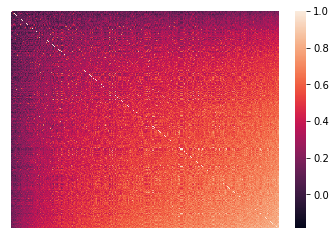

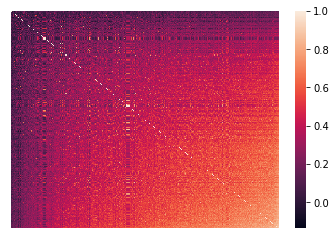

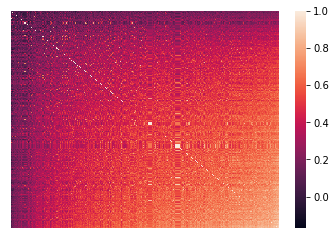

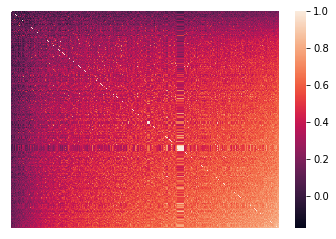

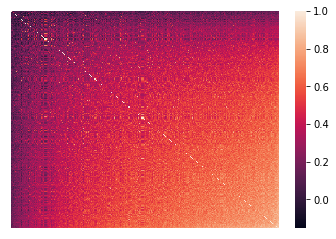

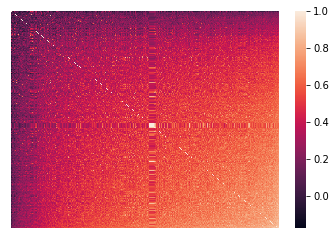

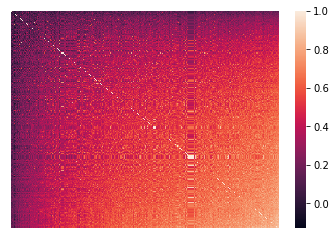

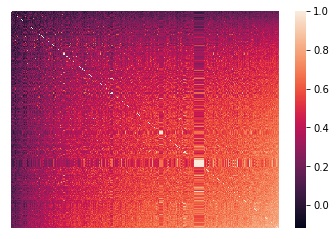

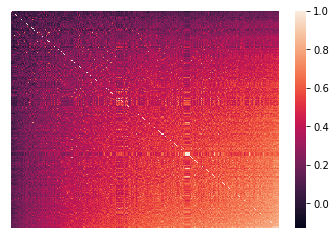

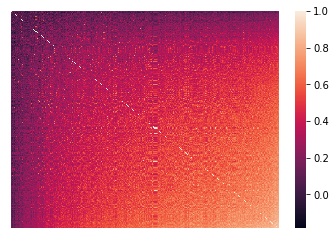

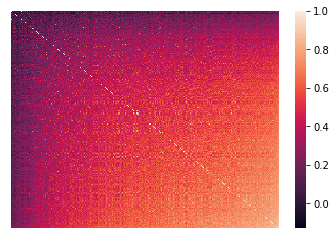

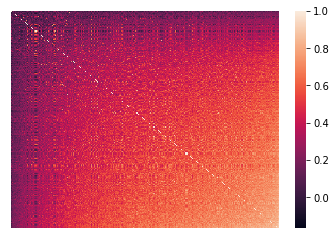

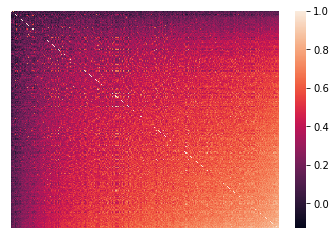

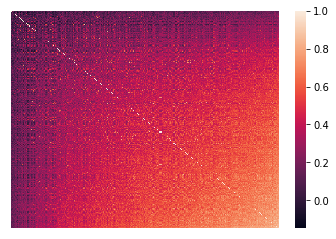

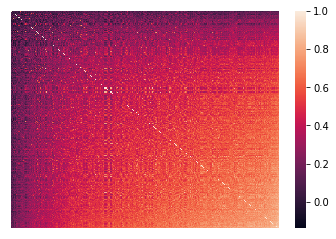

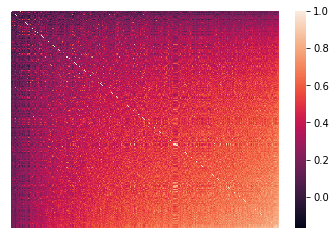

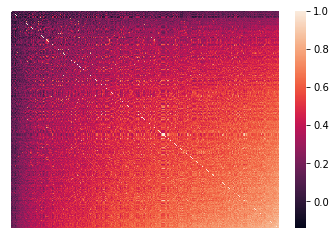

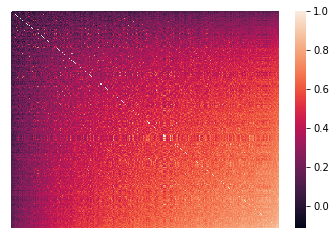

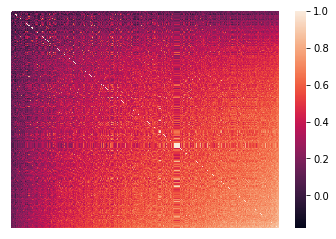

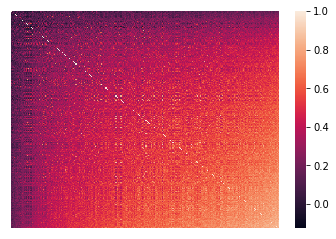

In [73]:
for i in cosine_similarity_matrix:
    indexlist = np.argsort(np.linalg.norm(i,axis=1))
    sym_sorted = i[indexlist][:,indexlist]
    ax = heatmap(sym_sorted,xticklabels=False, yticklabels=False)

    plt.show()

In [37]:
import pickle

with open('days_cs_sim', 'wb') as fp:
    pickle.dump(cosine_similarity_matrix, fp)